# Machine learning: prediction

Machine learning-trained algorithms can predict whether bioacoustic recordings contain a sound of interest. For instance, an algorithm trained how to detect the sound of a Wood Thrush can be used to predict where Wood Thrushes vocalize in a set of autonomous recordings. 

Note: 
- The Kitzes Lab, the developers of OpenSoundscape, pre-trained a series of [baseline machine learning models](https://pitt.box.com/s/a6jeamnew098vp5a9a7m1h9j5rce6t6y) that can be used to predict the presence of [506 species of common North American birds](https://pitt.app.box.com/s/d0snd1tyilscksbxc36q2slz6s4aa2ag). These are our "beta" models and are for demonstration purposes only, not for research use. We hope to make our more accurate models available soon. 
- If we are to use these machine learning models for research, contact the [Kitzes Lab](https://kitzeslab.org).
- There are example models provided by the Kitzes lab here:


## Import modules
Import the following modules to run a pre-trained machine learning learning classifier. First, from OpenSoundscape we will need two classes (`Audio` and `SingleTargetAudioDataset`) and three functions (`run_command`, `lowercase_annotations`, and `predict`).

In [13]:
from opensoundscape.audio import Audio
from opensoundscape.datasets import SingleTargetAudioDataset
from opensoundscape.helpers import run_command
from opensoundscape.raven import lowercase_annotations
from opensoundscape.torch.predict import predict

Import the following machine learning-related modules. OpenSoundscape uses PyTorch to do machine learning.

In [14]:
import torch
import torch.nn
import torchvision.models
import torch.utils.data
import torchvision.transforms

Lastly, use a few miscellaneous functions.

In [15]:
import yaml
import os.path
import pandas as pd
from pathlib import Path
from math import floor

## Download model

To use the model, it must be downloaded onto your computer and loaded with the same specifications it was created with.

Download the example model for Wood Thrush, *Hylocichla mustelina*. First, create a folder called `"prediction_example"` to store the model and its data in.

To do: 
- Access the trained model

In [16]:
folder_name = "prediction_example"
folder_path = Path(folder_name)
if not folder_path.exists(): folder_path.mkdir()

## Load model
At its core, a machine learning model consists of two things: its architecture and its weights. 

The architecture is the complex structure of the model, which in this case, is a convolutional neural network. Convolutional neural networks are a particular set of algorithms especially suited to extracting and interpreting features from images, such as combinations of lines, dots, and edges. In this case, we use a `resnet18` convolutional neural network. After feature extraction, the convolutional neural network's features are passed to a classifier. The classifier decides how to weight each feature in predicting the final class identity. The model was trained with a `Linear` classifier.

Create the architecture of the model. First, designate the model as a `resnet18` CNN.

In [17]:
model = torchvision.models.resnet18(pretrained=False)

Then, add the `fc` layers. "FC" stands for "fully connected". To set up the proper architecture, we need to specify the correct number of input features, output features, and classifier type. 

The number of input features to the FC is equal to the number of features extracted from the convolutional neural network and passed to the the FC layer: `model.fc.in_features`

In [18]:
num_cnn_features = model.fc.in_features

The models were trained to predict two classes (bird present and bird absent), so the number of output features of the FC layer is 2.

In [19]:
num_classes = 2

Finally, the classifier type is a `torch.nn.Linear` classifier.

In [20]:
model.fc = torch.nn.Linear(
    in_features = num_cnn_features,
    out_features = num_classes)

The weights of the model are distinguished from its architecture because, while the architecture is decided by humans, the weights of the architecture are learned during the machine learning process. When downloading the machine learning model, you downloaded the weights. 

First, use `torch.load` to get the model weights from the filename.

In [26]:
epoch4 = torch.load('/home/e4e/Desktop/model_train_results/epoch-4.tar')
weights = epoch4['model_state_dict'] # the last epoch


In [27]:
print(epoch4)

{'train_loss': 0.7890156760811806, 'train_accuracy': 0.5, 'train_precision': array([0.25, 0.25]), 'train_recall': array([0.25, 0.25]), 'train_f1': array([0.25, 0.25]), 'valid_accuracy': 0.4, 'valid_precision': array([0.2, 0.2]), 'valid_recall': array([0.2, 0.2]), 'valid_f1': array([0.2, 0.2]), 'model_state_dict': OrderedDict([('conv1.weight', tensor([[[[-1.0409e-02, -5.9928e-03, -1.6379e-03,  ...,  5.6623e-02,
            1.7149e-02, -1.2817e-02],
          [ 1.1056e-02,  9.6819e-03, -1.0980e-01,  ..., -2.7124e-01,
           -1.2903e-01,  3.5866e-03],
          [-7.0291e-03,  5.9211e-02,  2.9559e-01,  ...,  5.1974e-01,
            2.5639e-01,  6.3415e-02],
          ...,
          [-2.7677e-02,  1.6099e-02,  7.2710e-02,  ..., -3.3282e-01,
           -4.2052e-01, -2.5800e-01],
          [ 3.0468e-02,  4.0996e-02,  6.2961e-02,  ...,  4.1386e-01,
            3.9363e-01,  1.6585e-01],
          [-1.3890e-02, -3.5967e-03, -2.3951e-02,  ..., -1.5066e-01,
           -8.2170e-02, -5.9570e-03]

Checking the key of the weights of the epoch compared to the example weights. 

In [28]:
print('type(weights)', type(weights))


type(weights) <class 'collections.OrderedDict'>


Now, load the weights into the architecture we have created. After this the model is almost ready to use.

In [30]:
model.load_state_dict(weights)

<All keys matched successfully>

## Prepare prediction files

To actually use the model, we need to download and prepare a set of recordings. The model was trained to make predictions on spectrograms made from 10 second-long recordings (from 'train-xenocanto-binary-bird-classifier' file), so we will have to split the recordings up and transform them into spectrograms.

As example data, we have provided a 1 minute-long soundscape which contains Wood Thrush vocalizations. 

For reference check out this [link](https://github.com/kitzeslab/opensoundscape/blob/master/docs/predict.ipynb)

The example soundscape must be split up into soundscapes of the same size as the ones the model was trained on. In this case, the soundscapes should be 10s long.

First, create a directory in which to save split files.

In [31]:
split_directory = folder_path.joinpath("/home/e4e/Desktop/binary_bird_small_testset")
print(split_directory)

/home/e4e/Desktop/binary_bird_small_testset


Now, we want to set a list of directories for each file. If you are on a mac then make sure to use the folloding bash command: find . -name ".DS_Store" -delete" in order to delete the .DS_Store file. 

In [32]:
all_file_dir = []
all_file_names = [] # get rid of the file extension
for filename in os.listdir(split_directory): 
    all_file_names.append(os.path.splitext(filename)[0])
    filepath = os.path.join(split_directory, filename)
    all_file_dir.append(filepath)


To check the first couple of file directory strings and the filenames. 

In [33]:
print(all_file_dir[:10])
print(all_file_names[:10])

['/home/e4e/Desktop/binary_bird_small_testset/_8MvhMlbwiE_40.000.wav', '/home/e4e/Desktop/binary_bird_small_testset/_6spzSHLoY0_30.000.wav', '/home/e4e/Desktop/binary_bird_small_testset/_7AHvLZsXFQ_580.000.wav', '/home/e4e/Desktop/binary_bird_small_testset/_8HcEdMMbzQ_130.000.wav', '/home/e4e/Desktop/binary_bird_small_testset/XC22019 - Blue-crowned Trogon - Trogon curucui.mp3', '/home/e4e/Desktop/binary_bird_small_testset/XC22211 - White-bellied Tody-Tyrant - Hemitriccus griseipectus.mp3', '/home/e4e/Desktop/binary_bird_small_testset/XC22072 - Sapphire-spangled Emerald - Amazilia lactea.mp3', '/home/e4e/Desktop/binary_bird_small_testset/XC22279 - Greyish Mourner - Rhytipterna simplex.mp3', '/home/e4e/Desktop/binary_bird_small_testset/_3ZOigx8e3c_30.000.wav', '/home/e4e/Desktop/binary_bird_small_testset/_5mfNxFuXos_30.000.wav']
['_8MvhMlbwiE_40.000', '_6spzSHLoY0_30.000', '_7AHvLZsXFQ_580.000', '_8HcEdMMbzQ_130.000', 'XC22019 - Blue-crowned Trogon - Trogon curucui', 'XC22211 - White-bel

Next, load the files as an `Audio` object and then split the recording in the audio object into segments of a specified length. Here, we split the clips into a 10s length, specify the directory they should be saved in (the `split_directory` just created) and specify the prefix of the file.

In [34]:
for i in range(len(all_file_dir)): 
    base_file = Audio.from_file(all_file_dir[i])
    
    base_file.split_and_save(
        clip_length=10,
        destination=split_directory,
        name=all_file_names[i]
    ) 
    

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/opensoundscape/audio.py:250: UserWarning: clip_length 10 was longer than total length 6.034285714285715
  warnings.warn(
/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/opensoundscape/audio.py:250: UserWarning: clip_length 10 was longer than total length 4.179591836734694
  warnings.warn(
/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/opensoundscape/audio.py:250: UserWarning: clip_length 10 was longer than total length 7.523265306122449
  warnings.warn(
/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/opensoundscape/audio.py:250: UserWarning: clip_length 10 was longer than total length 7.523265306122449
  warnings.warn(


Note that split_and_save outputs one .csv file for each file. So, let us compile all the .csv files into one in this for loop.

In [35]:
import glob
os.chdir(split_directory)

extension = 'csv'
csv_filenames = [i for i in glob.glob('*.{}'.format(extension))]
csv_filenames = [f for f in csv_filenames if not f.endswith('combined_csv.csv')]

#combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in csv_filenames], ignore_index = True)

combined_csv = pd.concat([pd.read_csv(f, index_col='file')
    for f in csv_filenames], ignore_index=False
)

# '''
# combined_csv = pd.concat([pd.read_csv(f) for f in csv_filenames],
#     ignore_index=True
# )
# print(combined_csv.file.isnull().sum())
# combined_csv.set_index('file', inplace=True)
# '''


#export to csv
# combined_csv.to_csv("combined_csv.csv", index=True)

# print(combined_csv.columns)
# print(combined_csv['file'])

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The output of this function, `split_files`, is a dataframe which identifies the filename of each split and its start and end times:

In [36]:
combined_csv

,start_time,end_time
file,,
_8MvhMlbwiE_40.000_0s-10s.wav,0,10
XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav,0,10
_5FQFj1d9Qs_550.000_0s-10s.wav,0,10
_8HcEdMMbzQ_130.000_0s-10s.wav,0,10
_7AHvLZsXFQ_580.000_0s-10s.wav,0,10
_4oW93l094k_30.000_0s-10s.wav,0,10
_6spzSHLoY0_30.000_0s-10s.wav,0,10
_3F2ThHyn64_30.000_0s-10s.wav,0,10
_4rolMIFkgQ_30.000_0s-10s.wav,0,10


In [37]:
combined_csv.head()

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,start_time,end_time
file,,
_8MvhMlbwiE_40.000_0s-10s.wav,0,10
XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav,0,10
_5FQFj1d9Qs_550.000_0s-10s.wav,0,10
_8HcEdMMbzQ_130.000_0s-10s.wav,0,10
_7AHvLZsXFQ_580.000_0s-10s.wav,0,10


Prepend the "file" index with the directory in which the files are found so that the computer can refer to the files:

In [38]:
print(combined_csv.index)
print(combined_csv)

Index(['_8MvhMlbwiE_40.000_0s-10s.wav',
       'XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav',
       '_5FQFj1d9Qs_550.000_0s-10s.wav', '_8HcEdMMbzQ_130.000_0s-10s.wav',
       '_7AHvLZsXFQ_580.000_0s-10s.wav', '_4oW93l094k_30.000_0s-10s.wav',
       '_6spzSHLoY0_30.000_0s-10s.wav', '_3F2ThHyn64_30.000_0s-10s.wav',
       '_4rolMIFkgQ_30.000_0s-10s.wav',
       'XC22099 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav',
       '_5mfNxFuXos_30.000_0s-10s.wav',
       'XC22193 - Red-necked Woodpecker - Campephilus rubricollis_0s-10s.wav',
       'XC22087 - Silky-tailed Nightjar - Antrostomus sericocaudatus_0s-10s.wav',
       'XC22087 - Silky-tailed Nightjar - Antrostomus sericocaudatus_10s-20s.wav',
       'XC22211 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav',
       'XC22211 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_10s-20s.wav',
       'XC22211 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_20s-30

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# combined_csv['file_path']
print(type(combined_csv.index))
print(combined_csv.index) #need to change into chronological order
print(type(combined_csv))
print(combined_csv)

combined_csv['file_path'] = [split_directory.joinpath(csv) for csv in combined_csv.index]


<class 'pandas.core.indexes.base.Index'>
Index(['_8MvhMlbwiE_40.000_0s-10s.wav',
       'XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav',
       '_5FQFj1d9Qs_550.000_0s-10s.wav', '_8HcEdMMbzQ_130.000_0s-10s.wav',
       '_7AHvLZsXFQ_580.000_0s-10s.wav', '_4oW93l094k_30.000_0s-10s.wav',
       '_6spzSHLoY0_30.000_0s-10s.wav', '_3F2ThHyn64_30.000_0s-10s.wav',
       '_4rolMIFkgQ_30.000_0s-10s.wav',
       'XC22099 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav',
       '_5mfNxFuXos_30.000_0s-10s.wav',
       'XC22193 - Red-necked Woodpecker - Campephilus rubricollis_0s-10s.wav',
       'XC22087 - Silky-tailed Nightjar - Antrostomus sericocaudatus_0s-10s.wav',
       'XC22087 - Silky-tailed Nightjar - Antrostomus sericocaudatus_10s-20s.wav',
       'XC22211 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav',
       'XC22211 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_10s-20s.wav',
       'XC22211 - White-bellied Tody

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create a Dataset

Now that the data are split, we can create a "dataset" from them. 

To create a dataset requires that we create a dictionary that associates numeric labels with the class names: 1 is for predicting a bird's presence; 0 is for predicting a bird's absence. In more recent versions of the model, this label dictionary is packaged with the model download.

In [40]:
label_dict = {0:'bird-absent', 1:'bird-present'}

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we create a `SingleTargetAudioDataset`. This structure enables the data to be transformed into spectrograms when `test_dataset` is accessed.

In [41]:
test_dataset = SingleTargetAudioDataset(
    combined_csv,
    filename_column = "file_path",
    label_dict = label_dict
)

The `test_dataset` is a list of dictionaries. Each element of the list contains a dictionary for one of the files to predict on.

In [42]:
len(test_dataset)

25

Each dictionary in `test_dataset` has one or two keys. In all cases, the dictionary has a key `'X'` which refers to the spectrogram. If a dataset is created with true labels, the dictionary also has a `'y'` key which links to the true label. Because it is unknown which of these files contain Wood Thrush songs, no true labels were given when creating the dataset.

The spectrogram itself is stored as a PyTorch tensor. For example, here is the tensor of the first spectrogram:

In [43]:
first_tensor = test_dataset[0]['X']
first_tensor

tensor([[[0.5765, 0.6510, 0.6235,  ..., 0.7804, 0.7922, 0.8000],
         [0.5490, 0.5137, 0.6078,  ..., 0.6941, 0.7451, 0.7608],
         [0.4549, 0.5529, 0.6824,  ..., 0.6902, 0.7451, 0.7137],
         ...,
         [0.1686, 0.2314, 0.1608,  ..., 0.3098, 0.1843, 0.0431],
         [0.3843, 0.3882, 0.2588,  ..., 0.4275, 0.2863, 0.0078],
         [0.5373, 0.4941, 0.3961,  ..., 0.4314, 0.2980, 0.1608]],

        [[0.5765, 0.6510, 0.6235,  ..., 0.7804, 0.7922, 0.8000],
         [0.5490, 0.5137, 0.6078,  ..., 0.6941, 0.7451, 0.7608],
         [0.4549, 0.5529, 0.6824,  ..., 0.6902, 0.7451, 0.7137],
         ...,
         [0.1686, 0.2314, 0.1608,  ..., 0.3098, 0.1843, 0.0431],
         [0.3843, 0.3882, 0.2588,  ..., 0.4275, 0.2863, 0.0078],
         [0.5373, 0.4941, 0.3961,  ..., 0.4314, 0.2980, 0.1608]],

        [[0.5765, 0.6510, 0.6235,  ..., 0.7804, 0.7922, 0.8000],
         [0.5490, 0.5137, 0.6078,  ..., 0.6941, 0.7451, 0.7608],
         [0.4549, 0.5529, 0.6824,  ..., 0.6902, 0.7451, 0.

To view this spectrogram, use PyTorch's `transforms.ToPILImage()` function. This function returns a transformer. Call the transformer on the first tensor to display the spectrogram as an image.

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


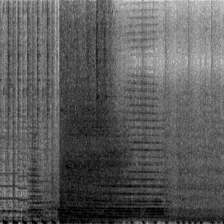

In [44]:
transformer = torchvision.transforms.ToPILImage()
transformer(first_tensor)

## Use model on prediction files

Finally, the model can be used for prediction. Use OpenSoundscape's `predict` function to call the model on the test dataset. The `label_dict` created above is used to make the classes interpretable; otherwise, the classes would just be numbered.

Official documentation of train function from opensoundscape is [here](https://github.com/kitzeslab/opensoundscape/blob/master/opensoundscape/torch/predict.py)

Notes: 
What is tensor?
"A PyTorch Tensor is basically the same as a numpy array: it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array to be used for arbitrary numeric computation." [source](https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html)

Probability score: 
- Input a binary pytorch model
- Uses enumerate(dataloader) for multi-process data loading
- Uses softmax function which outputs numbers that represent probabilities where each number's value is between 0 and 1

Questions: 
- What is the range of numbers here and what do they represent? 
- What is Dataloader?

In [45]:
prediction_df = predict(model, test_dataset, apply_softmax=True, label_dict=label_dict)

In [46]:
prediction_df

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bird-absent,bird-present
/home/e4e/Desktop/binary_bird_small_testset/_8MvhMlbwiE_40.000_0s-10s.wav,0.336660,0.663340
/home/e4e/Desktop/binary_bird_small_testset/XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav,0.322523,0.677477
/home/e4e/Desktop/binary_bird_small_testset/_5FQFj1d9Qs_550.000_0s-10s.wav,0.361814,0.638187
/home/e4e/Desktop/binary_bird_small_testset/_8HcEdMMbzQ_130.000_0s-10s.wav,0.228530,0.771470
/home/e4e/Desktop/binary_bird_small_testset/_7AHvLZsXFQ_580.000_0s-10s.wav,0.624181,0.375819
/home/e4e/Desktop/binary_bird_small_testset/_4oW93l094k_30.000_0s-10s.wav,0.203302,0.796698
/home/e4e/Desktop/binary_bird_small_testset/_6spzSHLoY0_30.000_0s-10s.wav,0.319684,0.680316
/home/e4e/Desktop/binary_bird_small_testset/_3F2ThHyn64_30.000_0s-10s.wav,0.318630,0.681370
/home/e4e/Desktop/binary_bird_small_testset/_4rolMIFkgQ_30.000_0s-10s.wav,0.596630,0.403370
/home/e4e/Desktop/binary_bird_small_testset/XC22099 - White-bellied Tody-Tyrant - Hemitriccus griseipectus_0s-10s.wav,0.289986,0.710014


Let us save the results of the model being used for prediction as a csv.

In [47]:
prediction_df.to_csv('prediction_results.csv')

/home/e4e/acoustic-species-id-environments/Yoo-Jin/opensoundscape/opensoundscape-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finally, this command "cleans up" by deleting all the downloaded files and results. Only run this if you are ready to remove the results of this analysis.

In [ ]:
import shutil
shutil.rmtree(folder_path)